# atlases

In [1]:
# from importlib import reload
# import sys
# reload(sys.modules["util.atlas"])

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

from util import plot
from neuromaps.transforms import mni152_to_fsaverage
from matplotlib.colors import ListedColormap
from util.atlas import Atlas

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


## load atlases

In [3]:
# from nilearn.datasets import fetch_atlas_surf_destrieux
# bunch = fetch_atlas_surf_destrieux(data_dir='mats')
# idsL = bunch['map_left']
# idsR = bunch['map_right']
# labels = bunch['labels']
# # 10242, need to upsample
# len(idsL)

In [4]:
schaefer = Atlas.schaefer()
glasser = Atlas.glasser2016()
lana_atlas = Atlas.lana2022()
lang_atlas = Atlas.ev2010()

In [5]:
# load narratives data
gLh = nib.load("mats/narratives-group_space-fsaverage6_hemi-L_desc-mean_isc.gii")
gRh = nib.load("mats/narratives-group_space-fsaverage6_hemi-R_desc-mean_isc.gii")
left_data = gLh.agg_data()
right_data = gRh.agg_data()
narratives = np.concatenate((left_data, right_data))
narratives[np.isnan(narratives)] = 0
narratives.min(), narratives.max()

(-0.00810998930166869, 0.613491946194624)

In [6]:
# neursoynth lang
gifL, gifR = mni152_to_fsaverage("mats/language_association-test_z_FDR_0.01.nii.gz")
ns_lang = np.concatenate((gifL.agg_data(), gifR.agg_data()))
ns_lang.min(), ns_lang.max()

(-4.1486516, 15.034099)

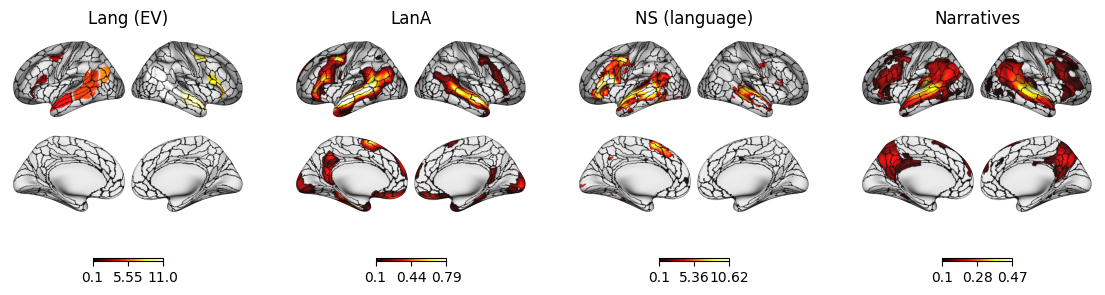

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(14, 6))
plot.surface_plot(lang_atlas.label_img, vmin=0.1, threshold=0, cmap="hot", atlas=glasser, fig=fig, ax=axes[0], title="Lang (EV)")
plot.surface_plot(lana_atlas.label_img, vmin=0.1, threshold=0.1, cmap="hot", atlas=glasser, fig=fig, ax=axes[1], title="LanA")
plot.surface_plot(ns_lang, vmin=0.1, threshold=2, cmap="hot", atlas=glasser, fig=fig, ax=axes[2], title="NS (language)")
plot.surface_plot(narratives, vmin=0.1, threshold=0.1, cmap="hot", atlas=glasser, fig=fig, ax=axes[3], title="Narratives")
fig.show()

## build composite overlay

In [10]:
# binarize
lang_bin = (lang_atlas.label_img > 0).astype(np.int32)
lana_bin = (lana_atlas.label_img > 0.1).astype(np.int32)
nslg_bin = (ns_lang > 2).astype(np.int32)
nara_bin = (narratives > 0.1).astype(np.int32)

composite = lang_bin + lana_bin + nslg_bin + nara_bin
# composite = lana_bin + nslg_bin + nara_bin
np.max(composite)

4

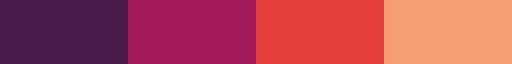

In [11]:
colors = sns.color_palette("rocket", 4).as_hex()
cmap = ListedColormap(colors, "intensity", N=4)
cmap

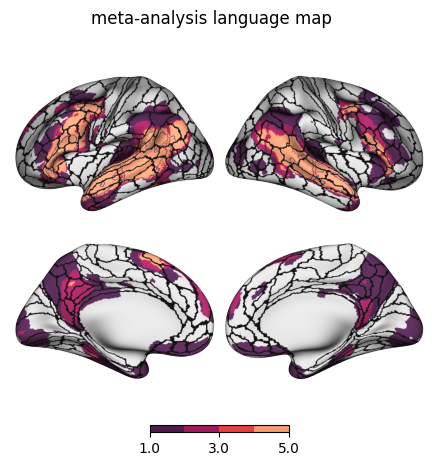

In [12]:
fig = plot.surface_plot(
    composite,
    vmin=1,
    vmax=5,
    cmap=cmap,
    atlas=glasser,
    title="meta-analysis language map",
)

# custom atlases

## custom glasser atlas

In [5]:
atlas = glasser
atlas_labels = set(atlas.labels)

In [6]:
glasser_rois = {

    # Glasser 10. Early auditory cortex
    # included all parcels
    # in story, we see A4 also load onto spectral embeddings a little bit.
    "EAC_EAC": ["A1", "LBelt", "MBelt", "PBelt", "RI"],

    # Glasser 15. Tempo-parieto-occipital junction
    # divided all parcels except TPOJ3 into ventral/dorsal sections
    # both these divisions overlap with LanA and LanG. And story LLM encoding
    "pSTG_AG": ["TPOJ1", "TPOJ2"],
    "pSTG_SMG": ["STV", "PSL"],

    # Glasser 11. Auditory association cortex
    # divide all parcels except TA2 into STG, and ant/post STS
    # TA2 is not reflected in LanA, LanG. It loads a bit onto spectral embeddings in story
    # A4 is not in LanG or LanA. but has articulatory features in story more than spectral
    "aSTG_STG": ["A4", "A5"],
    "aSTG_aSTS": ["STSda", "STSva", "STGa"],
    "aSTG_pSTS": ["STSdp", "STSvp"],

    # Glasser 21. Inferior frontal cortex
    # glasser defines these parcels as inferior frontal sulcus:
    "IFG_IFJ": ["IFJp", "IFJa"],
    "IFG_IFS": ["IFSp", "IFSa"],
    # These IFG parcels are within Lan*, but partially combine across IFGorb and IFG
    "IFG_IFG": ["44", "45", "47l"],

    # Glasser 12. Insular and frontal opercular cortex
    # chose these 3 parcels as the most anterior part of insula, under IFG
    # connected to arcuate fasiculus
    # as it shows some activatin in LanA and expected to in production
    "FOP_FOP": ["FOP4", "FOP5", "AVI"],

    # Glasser 8. Premotor cortex
    # LanG defines MFG as 55b and FEF, but we also add PEF because it's in LanA
    "MFG_MFG": ["55b", "FEF", "PEF"],

    # Glasser 6. Somatosensory and motor cortex
    # We exlcude areas 1 and 2 in somatosensory. Why? besides no good encoding?
    "SM_M1": ["4"],
    "SM_S1": ["3a", "3b"],

    # Glasser 22. Dorsolateral prefrontal cortex
    # Glasser 7. Supplementary motor areas
    # both these areas are physically close but from different networks
    # they are activated in LanA and narratives. SFL is in story encoding
    # consider merging or just keeping SFL since it's language
    "SMA_SFL1": ["SFL"],  # superior frontal language
    "SMA_SFL2": ["SCEF"],  # supplementary and	cingulate eye fields

    # Glasser 16. Superior parietal cortex
    "IPS_SPC": ["LIPd", "LIPv", "VIP", "AIP", "MIP"],
    "IPS_dIPC": ["IP0", "IP1", "IP2"],

    # Glasser 17. Inferior parietal cortex
    # PGi and PGs match Lan* in between PostTemp and AngG areas
    # Lan* include TPOJ3 here, which we exclude to stay within Glasser networks
    "TPJ_IPC1": ["PGi", "PGs"],
    "TPJ_IPC2": ["PFm"],

    # Glasser 18. Posterior cincular cortex
    "PMC_PCC1": ["31pv", "31pd", "v23ab", "d23ab", "POS1", "7m", "PCV"],
    "PMC_PCC3": ["POS2"],
    "PMC_SPC1": ["7Pm", "7Am"],
}

# separate into hemispheres
rois = {}
for name, labels in glasser_rois.items():
    rois[f"LH_{name}"] = [f"L_{label}" for label in labels]
for name, labels in glasser_rois.items():
    rois[f"RH_{name}"] = [f"R_{label}" for label in labels]

len(rois)

44

In [7]:
# table: ROI, group, n_parcels, parcels
records = []
for name, parcels in glasser_rois.items():
    records.append({
        'group': name.split('_')[0],
        'name': name.split('_')[1],
        'n_parcels': len(parcels),
        'glasser parcels': parcels
    })
df = pd.DataFrame(records)
print(df.n_parcels.sum(), 'glasser parcels\t', len(df.group.unique()), 'groups')
df

55 glasser parcels	 11 groups


,group,name,n_parcels,glasser parcels
0,EAC,EAC,5,"[A1, LBelt, MBelt, PBelt, RI]"
1,pSTG,AG,2,"[TPOJ1, TPOJ2]"
2,pSTG,SMG,2,"[STV, PSL]"
3,aSTG,STG,2,"[A4, A5]"
4,aSTG,aSTS,3,"[STSda, STSva, STGa]"
5,aSTG,pSTS,2,"[STSdp, STSvp]"
6,IFG,IFJ,2,"[IFJp, IFJa]"
7,IFG,IFS,2,"[IFSp, IFSa]"
8,IFG,IFG,3,"[44, 45, 47l]"
9,FOP,FOP,3,"[FOP4, FOP5, AVI]"


In [8]:
label_img = np.zeros_like(atlas.label_img)
group_img = np.zeros_like(atlas.label_img)

uniq_nets = df.group.unique().tolist()
uniq_nets = ['LH_' + net for net in uniq_nets] + ['RH_' + net for net in uniq_nets]
net_lut = {net: i for i, net in enumerate(uniq_nets, 1)}

labels = {0: "???"}
for i, (k, v) in enumerate(rois.items(), 1):
    assert all(lb in atlas_labels for lb in v)
    mask = atlas.roimask(v)
    count = mask.sum()
    label_img[mask] = i
    group_img[mask] = net_lut[k.rsplit('_', maxsplit=1)[0]] #.split("_")[1]]
    labels[i] = k
    print(i, k, count, v)
    assert count

custom_atlas = Atlas("custom_glasser", label_img, labels)
custom_atlas.save()
len(net_lut), len(custom_atlas)

1 LH_EAC_EAC 808 ['L_A1', 'L_LBelt', 'L_MBelt', 'L_PBelt', 'L_RI']
2 LH_pSTG_AG 361 ['L_TPOJ1', 'L_TPOJ2']
3 LH_pSTG_SMG 387 ['L_STV', 'L_PSL']
4 LH_aSTG_STG 425 ['L_A4', 'L_A5']
5 LH_aSTG_aSTS 406 ['L_STSda', 'L_STSva', 'L_STGa']
6 LH_aSTG_pSTS 499 ['L_STSdp', 'L_STSvp']
7 LH_IFG_IFJ 268 ['L_IFJp', 'L_IFJa']
8 LH_IFG_IFS 298 ['L_IFSp', 'L_IFSa']
9 LH_IFG_IFG 571 ['L_44', 'L_45', 'L_47l']
10 LH_FOP_FOP 613 ['L_FOP4', 'L_FOP5', 'L_AVI']
11 LH_MFG_MFG 465 ['L_55b', 'L_FEF', 'L_PEF']
12 LH_SM_M1 1001 ['L_4']
13 LH_SM_S1 1165 ['L_3a', 'L_3b']
14 LH_SMA_SFL1 221 ['L_SFL']
15 LH_SMA_SFL2 288 ['L_SCEF']
16 LH_IPS_SPC 1130 ['L_LIPd', 'L_LIPv', 'L_VIP', 'L_AIP', 'L_MIP']
17 LH_IPS_dIPC 584 ['L_IP0', 'L_IP1', 'L_IP2']
18 LH_TPJ_IPC1 771 ['L_PGi', 'L_PGs']
19 LH_TPJ_IPC2 614 ['L_PFm']
20 LH_PMC_PCC1 1075 ['L_31pv', 'L_31pd', 'L_v23ab', 'L_d23ab', 'L_POS1', 'L_7m', 'L_PCV']
21 LH_PMC_PCC3 302 ['L_POS2']
22 LH_PMC_SPC1 384 ['L_7Pm', 'L_7Am']
23 RH_EAC_EAC 638 ['R_A1', 'R_LBelt', 'R_MBelt', 'R_PBelt

(22, 44)

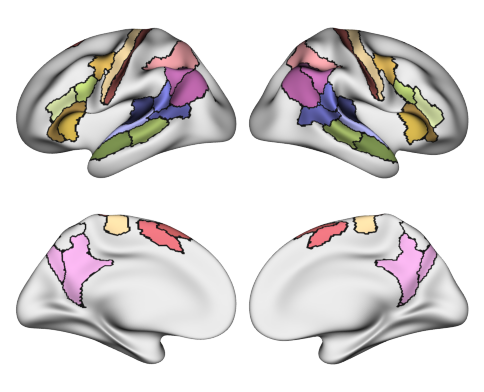

In [9]:
fig = plot.surface_plot(
    label_img % 22,
    vmin=0,
    cmap="tab20b",
    cbar=False,
    # surf_lh_fn=None,
    atlas=custom_atlas,
    brightness=0.7,
)  # , views='lateral', zoom=1.2)

In [10]:
groupLabels = {0: '???'}
groupLabels |= {i: roi for roi, i in net_lut.items()}
groupLabels

{0: '???',
 1: 'LH_EAC',
 2: 'LH_pSTG',
 3: 'LH_aSTG',
 4: 'LH_IFG',
 5: 'LH_FOP',
 6: 'LH_MFG',
 7: 'LH_SM',
 8: 'LH_SMA',
 9: 'LH_IPS',
 10: 'LH_TPJ',
 11: 'LH_PMC',
 12: 'RH_EAC',
 13: 'RH_pSTG',
 14: 'RH_aSTG',
 15: 'RH_IFG',
 16: 'RH_FOP',
 17: 'RH_MFG',
 18: 'RH_SM',
 19: 'RH_SMA',
 20: 'RH_IPS',
 21: 'RH_TPJ',
 22: 'RH_PMC'}

In [11]:
custom_atlas2 = Atlas("custom_glasser_group", group_img, groupLabels)
custom_atlas2.save()

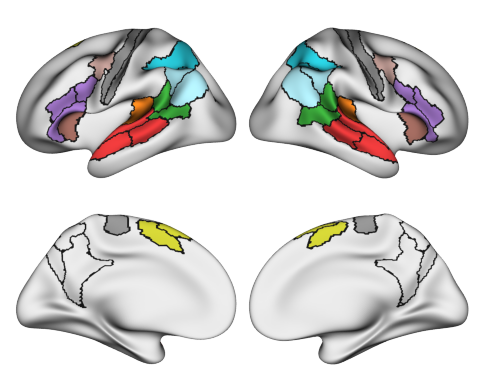

In [12]:
fig = plot.surface_plot(
    group_img % 11,
    vmin=0,
    cmap="tab20",
    cbar=False,
    # surf_lh_fn=None,
    atlas=custom_atlas, #Atlas("tmp", group_img, labels),
    brightness=0.7,
)  # , views='lateral', zoom=1.2)

### per-ROI plot

In [21]:
customNets = [net[3:] for net in list(net_lut.keys())[:len(net_lut)//2]]
customNets 

['EAC', 'pSTG', 'aSTG', 'IFG', 'MFG', 'SM', 'FOP', 'SMA', 'IPS', 'TPJ', 'PMC']

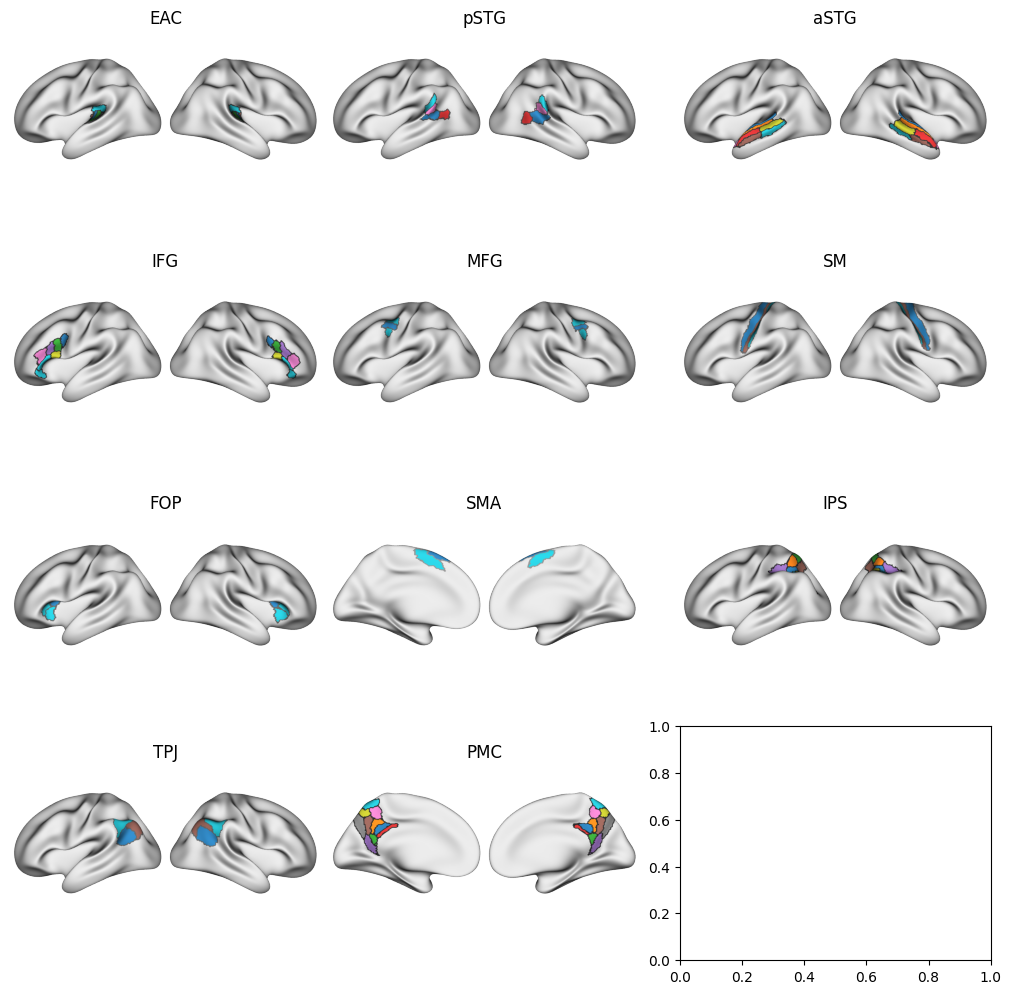

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(10, 10), layout='constrained')

for group, ax in zip(customNets, axes.ravel()):
    roiParcels = sum(df[df.group == group]['glasser parcels'].tolist(), [])
    # glasserParcels = [f'L_{r}' for r in roiParcels] + [f'R_{r}' for r in roiParcels]

    roi_img = np.zeros_like(atlas.label_img)
    for i, roiParcel in enumerate(roiParcels, 1):
        glasserParcels = [f'L_{roiParcel}', f'R_{roiParcel}']
        roimask = glasser.roimask(glasserParcels)
        roi_img[roimask] = i

    view = "medial" if group.startswith("PMC") or group.startswith("SMA") else "lateral"

    plot.surface_plot(roi_img, vmin=1, cmap="tab10", cbar=False, title=group,
                    atlas=Atlas("tmp", roi_img, labels),
                    size=(400, 200), zoom=1.2, views=view,
                    fig=fig, ax=ax)

fig.show()

### group image

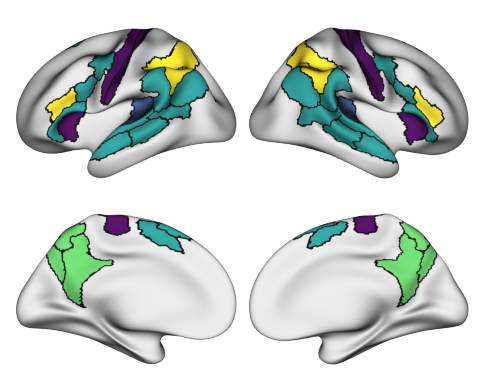

In [11]:
fig = plot.surface_plot(
    group_img, vmin=1, cmap="viridis", cbar=False, atlas=custom_atlas
)

In [11]:
# save parcel version
atlas = glasser
label_img = np.zeros_like(atlas.label_img)
labels = {0: "???"}
i = 1
for k, v in rois.items():
    for p in v:
        mask = atlas.roimask([p])
        count = mask.sum()
        label_img[mask] = i
        labels[i] = k + "_" + p[2:]
        i += 1
        assert count

custom_atlas = Atlas("custom_glasser_parc", label_img, labels)
custom_atlas.save()
len(custom_atlas)

112

## lang glasser atlas

unused

In [13]:
# from LanAtlas paper SI-1 fig
ev_glasser_rois = {
    "LangTemp_AntTemp": ["TA2", "STSva", "STSda", "STGa", "PI", "A5"],
    "LangTemp_PostTemp": [
        "TPOJ1",
        "TPOJ2",
        "STV",
        "STSvp",
        "STSdp",
        "PSL",
        "PHT",
        "PGi",
    ],
    "LangTemp_AngG": ["TPOJ3", "PGs"],
    "LangFrnt_MFG": ["FEF", "55b"],
    "LangFrnt_IFG": ["IFSp", "IFJa", "44"],
    "LangFrnt_IFGorb": ["47l", "45"],
}

# from https://doi.org/10.1093%2Fons%2Fopy257
dmn_rois = {
    # DMN was split into three regions
    "DMN_LatPar": ["PFm", "PGs", "PGi"],
    # 'AntCing': ['a24', 'p24', 'd32', '9M', '10r', '10v'],
    # 'PostCing': ['31a', '31pv', '31pd', 'v23ab', 'd23ab', '23d', 'RSC', '7m', 'POS1', 'POS2'],
    # the posterior region was further split into dorsal and ventral regions
    "DMN_vPCC": ["31pv", "31pd", "v23ab", "RSC"],
    # 'dPCC': ['31a', '23c', '23d', 'd23ab'],
}

custom_low = {
    # low-level areas
    "MOT_SM": ["3b", "3a", "4"],
    "AUD_EAC": ["A1", "LBelt", "PBelt", "A4"],  # from narratives + A4 - RI
}

custom_high = {
    "DMN_pCun": ["7m", "POS1", "POS2"],
    # add angular gyrus tpoj to this area for now...
    "DMN_LatPar": ["PFm", "PGs", "PGi", "TPOJ3"],
    # replace ev parcels to remove DMN parcels
    "LangTemp_PostTemp": [
        "TPOJ1",
        "TPOJ2",
        "STV",
        "STSvp",
        "STSdp",
        "PSL",
        "PHT",
    ],
}

custom_atlas_rois = custom_low | ev_glasser_rois | dmn_rois | custom_high

del custom_atlas_rois["LangTemp_AngG"]

# separate into hemispheres
rois = {}
for name, labels in custom_atlas_rois.items():
    rois[f"LH_{name}"] = [f"L_{label}" for label in labels]
for name, labels in custom_atlas_rois.items():
    rois[f"RH_{name}"] = [f"R_{label}" for label in labels]

len(rois)

20

In [ ]:
# from LanAtlas paper SI-1 fig
ev_glasser_rois = {
    "LangTemp_AntTemp": ["TA2", "STSva", "STSda", "STGa", "PI", "A5"],
    "LangTemp_PostTemp": [
        "TPOJ1",
        "TPOJ2",
        "STV",
        "STSvp",
        "STSdp",
        "PSL",
        "PHT",
        "PGi",
    ],
    "LangTemp_AngG": ["TPOJ3", "PGs"],
    "LangFrnt_MFG": ["FEF", "55b"],
    "LangFrnt_IFG": ["IFSp", "IFJa", "44"],
    "LangFrnt_IFGorb": ["47l", "45"],
}

# from https://doi.org/10.1093%2Fons%2Fopy257
dmn_rois = {
    # DMN was split into three regions
    "DMN_LatPar": ["PFm", "PGs", "PGi"],
    # 'AntCing': ['a24', 'p24', 'd32', '9M', '10r', '10v'],
    # 'PostCing': ['31a', '31pv', '31pd', 'v23ab', 'd23ab', '23d', 'RSC', '7m', 'POS1', 'POS2'],
    # the posterior region was further split into dorsal and ventral regions
    "DMN_vPCC": ["31pv", "31pd", "v23ab", "RSC"],
    # 'dPCC': ['31a', '23c', '23d', 'd23ab'],
}

custom_low = {
    # low-level areas
    "MOT_SM": ["3b", "3a", "4"],
    "AUD_EAC": ["A1", "LBelt", "PBelt", "A4"],  # from narratives + A4 - RI
}

custom_high = {
    "DMN_pCun": ["7m", "POS1", "POS2"],
    # add angular gyrus tpoj to this area for now...
    "DMN_LatPar": ["PFm", "PGs", "PGi", "TPOJ3"],
    # replace ev parcels to remove DMN parcels
    "LangTemp_PostTemp": [
        "TPOJ1",
        "TPOJ2",
        "STV",
        "STSvp",
        "STSdp",
        "PSL",
        "PHT",
    ],
}

custom_atlas_rois = custom_low | ev_glasser_rois | dmn_rois | custom_high

del custom_atlas_rois["LangTemp_AngG"]

# separate into hemispheres
rois = {}
for name, labels in custom_atlas_rois.items():
    rois[f"LH_{name}"] = [f"L_{label}" for label in labels]
for name, labels in custom_atlas_rois.items():
    rois[f"RH_{name}"] = [f"R_{label}" for label in labels]

len(rois)

20

In [22]:
atlas = glasser
label_img = np.zeros_like(atlas.label_img)
# label_img = lang_atlas.copy()
labels = {0: "???"}
for i, (k, v) in enumerate(rois.items(), 1):
    mask = atlas.roimask(v)
    count = mask.sum()
    label_img[mask] = i
    labels[i] = k
    print(i, k, count, v)
    assert count

custom_atlas = Atlas("langrois_glasser", label_img, labels)
custom_atlas.save()

1 LH_AntTemp 822 ['L_TA2', 'L_STSva', 'L_STSda', 'L_STGa', 'L_PI', 'L_A5']
2 LH_PostTemp 1905 ['L_TPOJ1', 'L_TPOJ2', 'L_STV', 'L_STSvp', 'L_STSdp', 'L_PSL', 'L_PHT', 'L_PGi']
3 LH_MFG 371 ['L_FEF', 'L_55b']
4 LH_IFG 442 ['L_IFSp', 'L_IFJa', 'L_44']
5 LH_IFGorb 399 ['L_47l', 'L_45']
6 LH_LatPar 1484 ['L_PFm', 'L_PGs', 'L_PGi', 'L_TPOJ3']
7 LH_vPCC 630 ['L_31pv', 'L_31pd', 'L_v23ab', 'L_RSC']
8 LH_SM 2166 ['L_3b', 'L_3a', 'L_4']
9 LH_EAC 902 ['L_A1', 'L_LBelt', 'L_PBelt', 'L_RI', 'L_A4']
10 LH_pCun 726 ['L_7m', 'L_POS1', 'L_POS2']
11 RH_AntTemp 953 ['R_TA2', 'R_STSva', 'R_STSda', 'R_STGa', 'R_PI', 'R_A5']
12 RH_PostTemp 2226 ['R_TPOJ1', 'R_TPOJ2', 'R_STV', 'R_STSvp', 'R_STSdp', 'R_PSL', 'R_PHT', 'R_PGi']
13 RH_MFG 318 ['R_FEF', 'R_55b']
14 RH_IFG 457 ['R_IFSp', 'R_IFJa', 'R_44']
15 RH_IFGorb 285 ['R_47l', 'R_45']
16 RH_LatPar 1534 ['R_PFm', 'R_PGs', 'R_PGi', 'R_TPOJ3']
17 RH_vPCC 633 ['R_31pv', 'R_31pd', 'R_v23ab', 'R_RSC']
18 RH_SM 2050 ['R_3b', 'R_3a', 'R_4']
19 RH_EAC 741 ['R_A1', 'R_

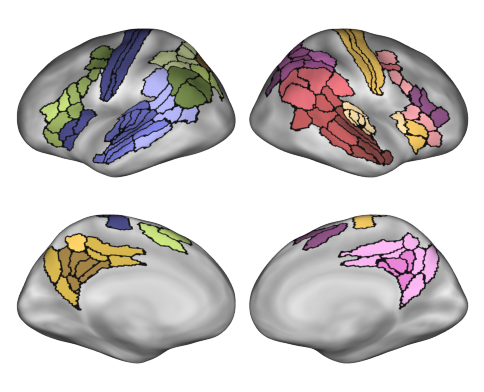

In [158]:
fig = plot.surface_plot(
    custom_atlas.label_img, vmin=1, cmap="tab20b", cbar=False, atlas=custom_atlas
)

In [157]:
atlas = glasser
label_img = np.zeros_like(atlas.label_img)
labels = {0: "???"}
i = 1
for k, v in rois.items():
    for p in v:
        mask = atlas.roimask([p])
        count = mask.sum()
        label_img[mask] = i
        labels[i] = k + "_" + p[2:]
        print(i, labels[i], count)
        i += 1
        assert count

custom_atlas = Atlas("langrois_glasser_parc", label_img, labels)
custom_atlas.save()
len(custom_atlas)

1 LH_MOT_M1_4 1001
2 LH_MOT_S1_3a 454
3 LH_MOT_S1_3b 711
4 LH_MOT_INS_FOP5 175
5 LH_MOT_INS_AVI 180
6 LH_MOT_INS_FOP4 258
7 LH_AUD_EAC_A1 101
8 LH_AUD_EAC_LBelt 145
9 LH_AUD_EAC_MBelt 146
10 LH_AUD_EAC_PBelt 186
11 LH_AUD_EAC_RI 230
12 LH_Lang_STG_A4 240
13 LH_Lang_STG_A5 185
14 LH_Lang_aSTS_STSda 159
15 LH_Lang_aSTS_STSva 171
16 LH_Lang_aSTS_STGa 76
17 LH_Lang_pSTS_STSdp 241
18 LH_Lang_pSTS_STSvp 258
19 LH_Lang_pTemp_TPOJ1 212
20 LH_Lang_pTemp_TPOJ2 149
21 LH_Lang_SMG_STV 169
22 LH_Lang_SMG_PSL 218
23 LH_Lang_SMG_PF 547
24 LH_Lang_IPC_PGi 440
25 LH_Lang_IPC_PGs 331
26 LH_Misc_IPC_PFm 614
27 LH_Lang_MFG_55b 161
28 LH_Lang_MFG_FEF 210
29 LH_Lang_MFG_PEF 94
30 LH_Lang_IFG_44 172
31 LH_Lang_IFG_45 237
32 LH_Lang_IFG_47l 162
33 LH_Lang_IFJ_IFJp 128
34 LH_Lang_IFJ_IFJa 140
35 LH_Misc_IFS_IFSp 130
36 LH_Misc_IFS_IFSa 168
37 LH_Lang_SFL1_SFL 221
38 LH_Lang_SFL2_SCEF 288
39 LH_Misc_dIPC_IP0 132
40 LH_Misc_dIPC_IP1 205
41 LH_Misc_dIPC_IP2 247
42 LH_Misc_SPC_LIPd 154
43 LH_Misc_SPC_LIPv 191
44 L

114

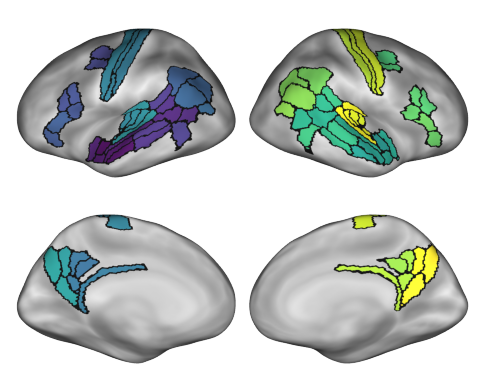

In [29]:
fig = plot.surface_plot(
    custom_atlas.label_img, vmin=0, cmap="viridis", cbar=False, atlas=custom_atlas
)

## custom schaefer atlas

unused

In [4]:
atlas = schaefer
lang_labels = lang_atlas.labels

In [45]:
# Pick parcels that overlap with lang atlas
threshold = 0.25

rois = {}
uniques = set()
for i, lang_label in enumerate(lang_labels, 1):
    ids, counts = np.unique(
        atlas.label_img[lang_atlas.label_img == i], return_counts=True
    )

    new_labels = []
    for parc_id, parc_count in zip(ids, counts):
        parc_label = atlas.label(parc_id)
        portion = parc_count / atlas.num_voxels(parc_id)
        if portion > threshold:
            new_labels.append(parc_label)
    #     print(lang_label, parc_label, parc_id, portion)
    # print()
    rois[lang_label] = new_labels
    uniques = uniques.union(new_labels)

    # doing this to keep all LH together
    if i == 6:
        rois["LH_SM"] = [
            lb
            for lb in atlas.labels
            if lb.startswith("17Networks_LH_SomMotB_Cent") and lb not in uniques
        ]
        rois["LH_EAC"] = [
            lb
            for lb in atlas.labels
            if lb.startswith("17Networks_LH_SomMotB_Aud") and lb not in uniques
        ]
        rois["LH_pCun"] = [
            lb
            for lb in atlas.labels
            if lb.startswith("17Networks_LH_DefaultA_pCunPCC") and lb not in uniques
        ]

rois["RH_EAC"] = [
    lb
    for lb in atlas.labels
    if lb.startswith("17Networks_RH_SomMotB_Aud") and lb not in uniques
]
rois["RH_SM"] = [
    lb
    for lb in atlas.labels
    if lb.startswith("17Networks_RH_SomMotB_Cent") and lb not in uniques
]
rois["RH_pCun"] = [
    lb
    for lb in atlas.labels
    if lb.startswith("17Networks_RH_DefaultA_pCunPCC") and lb not in uniques
]

# extend angular gyrus to include more DMN and less postTemp
# rois['LH_AngG'].extend([lb for lb in atlas.labels if lb.startswith('17Networks_LH_DefaultA_IPL')])
# rois['RH_AngG'].extend([lb for lb in atlas.labels if lb.startswith('17Networks_RH_DefaultA_IPL')])
# rois['LH_AngG'].extend([lb for lb in atlas.labels if lb.startswith('17Networks_LH_DefaultB_IPL')])  # NOTE maybe not all...
# rois['RH_AngG'].extend([lb for lb in atlas.labels if lb.startswith('17Networks_RH_DefaultB_IPL')])
# rois['LH_AngG'].extend([lb for lb in atlas.labels if lb.startswith('17Networks_LH_DefaultC_IPL')])
# rois['RH_AngG'].extend([lb for lb in atlas.labels if lb.startswith('17Networks_RH_DefaultC_IPL')])

len(rois)

18

In [46]:
# ensure no dupes
reverse = {}
for key, values in rois.items():
    for value in values:
        assert value not in reverse, f"{key}, {value}"
        reverse[value] = key

In [6]:
# # for testing
# # [lb for lb in atlas.labels if lb.startswith('17Networks_LH_TempPar')]
# rois = {'test': [lb for lb in atlas.labels if lb.startswith('17Networks_RH_TempPar')]}
# rois = {'test': [lb for lb in atlas.labels if lb.startswith('17Networks_LH_DefaultB_IPL')]}

In [47]:
label_img = np.zeros_like(atlas.label_img)
labels = {0: "???"}
for i, (k, v) in enumerate(rois.items(), 1):
    mask = atlas.roimask(v)
    count = mask.sum()
    label_img[mask] = i
    labels[i] = k
    print(i, k, count, v)
    assert count

custom_atlas = Atlas("langrois_schaefer", label_img, labels)
custom_atlas.save()

1 LH_IFGorb 279 ['17Networks_LH_DefaultB_PFCv_4', '17Networks_LH_DefaultB_PFCv_6', '17Networks_LH_DefaultB_PFCv_7']
2 LH_IFG 392 ['17Networks_LH_SalVentAttnB_Ins_8', '17Networks_LH_ContA_PFCl_1', '17Networks_LH_ContA_PFCl_2', '17Networks_LH_ContA_PFClv_2', '17Networks_LH_DefaultB_PFCv_9']
3 LH_MFG 354 ['17Networks_LH_SomMotB_Cent_10', '17Networks_LH_DorsAttnB_FEF_1', '17Networks_LH_DorsAttnB_FEF_3', '17Networks_LH_DefaultB_PFCl_1']
4 LH_AntTemp 628 ['17Networks_LH_DefaultB_Temp_4', '17Networks_LH_DefaultB_Temp_5', '17Networks_LH_DefaultB_Temp_7', '17Networks_LH_TempPar_1', '17Networks_LH_TempPar_2', '17Networks_LH_TempPar_3']
5 LH_PostTemp 2212 ['17Networks_LH_SomMotB_Aud_14', '17Networks_LH_DorsAttnA_TempOcc_10', '17Networks_LH_DorsAttnB_TempOcc_2', '17Networks_LH_ContA_Temp_3', '17Networks_LH_ContB_Temp_3', '17Networks_LH_ContB_Temp_4', '17Networks_LH_DefaultB_Temp_8', '17Networks_LH_DefaultB_Temp_9', '17Networks_LH_DefaultB_Temp_10', '17Networks_LH_DefaultB_Temp_11', '17Networks_LH_

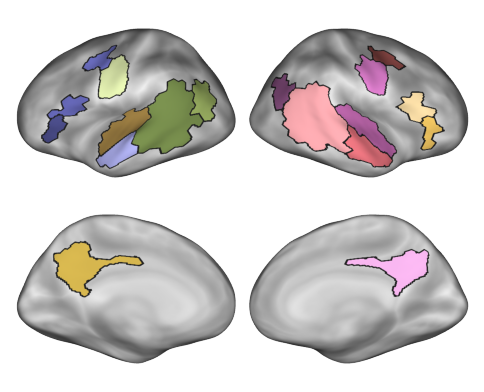

In [48]:
fig = plot.surface_plot(
    custom_atlas.label_img, vmin=1, cmap="tab20b", cbar=False, atlas=custom_atlas
)

In [49]:
atlas = schaefer
label_img = np.zeros_like(atlas.label_img)
labels = {0: "???"}
i = 1
for k, v in rois.items():
    for p in v:
        mask = atlas.roimask([p])
        count = mask.sum()
        label_img[mask] = i
        labels[i] = k + "_" + p[14:]
        print(i, labels[i], count)
        i += 1
        assert count

custom_atlas = Atlas("langrois_schaefer_parc", label_img, labels)
custom_atlas.save()
len(custom_atlas)

1 LH_IFGorb_DefaultB_PFCv_4 106
2 LH_IFGorb_DefaultB_PFCv_6 109
3 LH_IFGorb_DefaultB_PFCv_7 64
4 LH_IFG_SalVentAttnB_Ins_8 79
5 LH_IFG_ContA_PFCl_1 85
6 LH_IFG_ContA_PFCl_2 79
7 LH_IFG_ContA_PFClv_2 56
8 LH_IFG_DefaultB_PFCv_9 93
9 LH_MFG_SomMotB_Cent_10 101
10 LH_MFG_DorsAttnB_FEF_1 95
11 LH_MFG_DorsAttnB_FEF_3 42
12 LH_MFG_DefaultB_PFCl_1 116
13 LH_AntTemp_DefaultB_Temp_4 77
14 LH_AntTemp_DefaultB_Temp_5 64
15 LH_AntTemp_DefaultB_Temp_7 174
16 LH_AntTemp_TempPar_1 80
17 LH_AntTemp_TempPar_2 121
18 LH_AntTemp_TempPar_3 112
19 LH_PostTemp_SomMotB_Aud_14 124
20 LH_PostTemp_DorsAttnA_TempOcc_10 86
21 LH_PostTemp_DorsAttnB_TempOcc_2 51
22 LH_PostTemp_ContA_Temp_3 100
23 LH_PostTemp_ContB_Temp_3 66
24 LH_PostTemp_ContB_Temp_4 48
25 LH_PostTemp_DefaultB_Temp_8 59
26 LH_PostTemp_DefaultB_Temp_9 75
27 LH_PostTemp_DefaultB_Temp_10 86
28 LH_PostTemp_DefaultB_Temp_11 52
29 LH_PostTemp_DefaultB_Temp_12 67
30 LH_PostTemp_DefaultB_Temp_13 70
31 LH_PostTemp_DefaultB_IPL_1 60
32 LH_PostTemp_DefaultB_

209

In [16]:
at = Atlas.load("langrois_schaefer_parc")
len(at.labels)

229

In [18]:
import h5py

with h5py.File("mats/langrois_schaefer_parc.hdf5", "r") as f:
    label_img = f["label_img"][...]
    label_ids = f["ids"][...]
    label_names = f["labels"][...]

In [21]:
label_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [20]:
len(label_ids), len(label_names)

(241, 241)

In [ ]:
# for label, i in label2id.items():
#     regions = parc_mask == i
#     p = plot.get_surfplot(size=(800, 200), zoom=1.2, layout="row")
#     p.add_layer(regions, cmap="tab10", cbar=False)
#     p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
#     fig = p.build()
#     fig.supylabel(f"{i}:{label}", rotation=0)
#     fig.savefig(f"figures/glasser-rois/{label}-{i:03d}.png")
#     plt.close()
# plt.close()

# neurosynth

In [10]:
gifL, gifR = mni152_to_fsaverage("mats/social_association-test_z_FDR_0.01.nii")
social_act = np.concatenate((gifL.agg_data(), gifR.agg_data()))

In [5]:
gifL, gifR = mni152_to_fsaverage("mats/language_association-test_z_FDR_0.01.nii.gz")
social_act = np.concatenate((gifL.agg_data(), gifR.agg_data()))

In [3]:
gifL, gifR = mni152_to_fsaverage("mats/theory mind_association-test_z_FDR_0.01.nii")
social_act = np.concatenate((gifL.agg_data(), gifR.agg_data()))

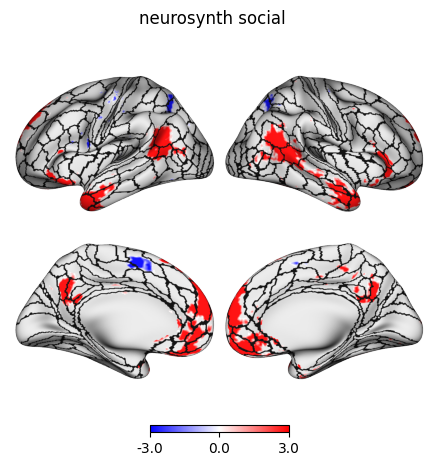

In [11]:
fig = plot.surface_plot(
    social_act, cmap="bwr", cbar=True, atlas=glasser, vmax=3, title="neurosynth social"
)

In [67]:
atlas = glasser
atlas_labels = atlas.labels

In [68]:
for label in atlas_labels:
    parc_mask = atlas.roimask([label])
    num_vox = parc_mask.sum()
    num_vox_act = (social_act[parc_mask] > 0).sum()
    ratio = num_vox_act / num_vox
    if ratio >= 0.75:
        print(label, ratio, num_vox, num_vox_act)

L_7m 0.8260869565217391 161 133
L_a24 0.8053097345132744 113 91
L_p32 0.9074074074074074 108 98
L_9m 0.9574468085106383 282 270
L_47s 0.8980891719745223 157 141
L_TE1a 0.8406593406593407 182 153
L_TPOJ2 0.87248322147651 149 130
L_PGi 0.7909090909090909 440 348
R_MT 0.8533333333333334 75 64
R_7m 0.7979274611398963 193 154
R_10r 0.9541284403669725 109 104
R_9m 0.8636363636363636 352 304
R_45 0.8616352201257862 159 137
R_47l 0.7619047619047619 126 96
R_10v 0.896969696969697 165 148
R_TE1a 0.8322981366459627 161 134
R_TPOJ1 0.878345498783455 411 361
R_TPOJ2 0.8743961352657005 207 181
R_PGi 0.8012048192771084 498 399
R_s32 0.8 80 64


In [69]:
rois = {
    "LH_TPJ": ["L_PGi", "L_TPOJ2"],
    "LH_IFG": [
        "L_47s",
    ],
    "LH_ATC": ["L_TE1a"],
    "LH_pCC": ["L_7m"],
    "LH_mPFC": ["L_9m", "L_a24"],
    "RH_TPJ": ["R_PGi", "R_TPOJ1", "R_TPOJ2", "R_MT"],
    "RH_IFG": ["R_45", "R_47l"],
    "RH_ATC": ["R_TE1a"],
    "RH_pCC": ["R_7m"],
    "RH_mPFC": ["R_9m", "R_s32", "R_10v", "R_10r"],
}

len(rois)

10

In [70]:
label_img = np.zeros_like(atlas.label_img)
labels = {0: "???"}
for i, (k, v) in enumerate(rois.items(), 1):
    assert all(lb in atlas_labels for lb in v)
    mask = atlas.roimask(v)
    count = mask.sum()
    label_img[mask] = i
    labels[i] = k
    print(i, k, count, v)
    assert count

custom_atlas = Atlas("ns_social_glasser", label_img, labels)
custom_atlas.save()
len(custom_atlas)

1 LH_TPJ 589 ['L_PGi', 'L_TPOJ2']
2 LH_IFG 157 ['L_47s']
3 LH_ATC 182 ['L_TE1a']
4 LH_pCC 161 ['L_7m']
5 LH_mPFC 395 ['L_9m', 'L_a24']
6 RH_TPJ 1191 ['R_PGi', 'R_TPOJ1', 'R_TPOJ2', 'R_MT']
7 RH_IFG 285 ['R_45', 'R_47l']
8 RH_ATC 161 ['R_TE1a']
9 RH_pCC 193 ['R_7m']
10 RH_mPFC 706 ['R_9m', 'R_s32', 'R_10v', 'R_10r']


10

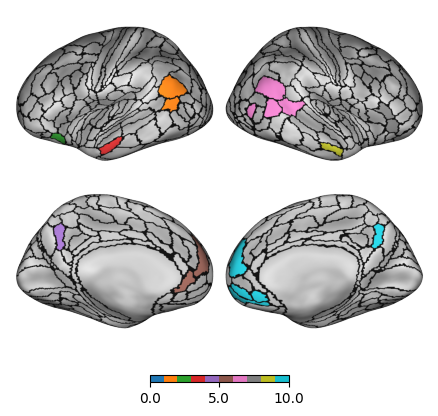

In [71]:
fig = plot.surface_plot(label_img, vmin=0, cmap="tab10", cbar=True, atlas=glasser)

# Test vis

In [10]:
from surfplot import Plot
from surfplot.utils import threshold

In [11]:
plot.get_surfplot()
lh_surf = plot._image_cache['mats/suma-fsaverage6/lh.inf_100.gii']
rh_surf = plot._image_cache['mats/suma-fsaverage6/rh.inf_100.gii']

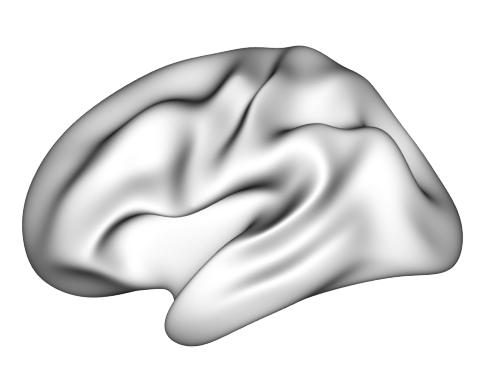

In [13]:
p = Plot(surf_lh=lh_surf, views='lateral', brightness=0.8)
fig = p.build()
fig.savefig('brain.svg')

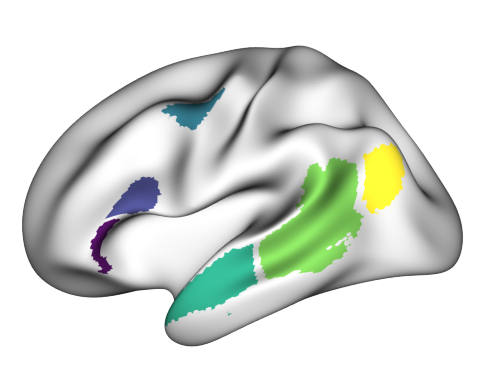

In [33]:
p = Plot(surf_lh=lh_surf, views='lateral', brightness=0.8)
p.add_layer(lang_atlas.label_img[:40962], cbar=False)
fig = p.build()

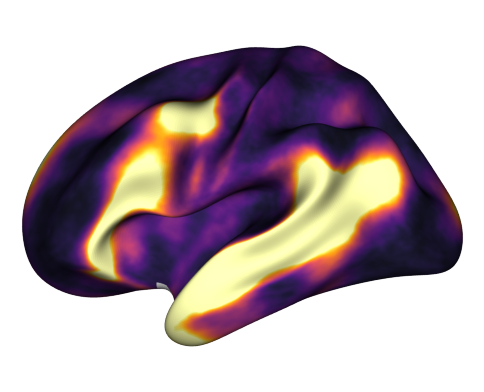

In [60]:
p = Plot(surf_lh=lh_surf, views='lateral', brightness=0.8)
p.add_layer(lana_atlas.label_img[:40962], cbar=False, cmap='inferno', color_range=(0, .3))
fig = p.build()

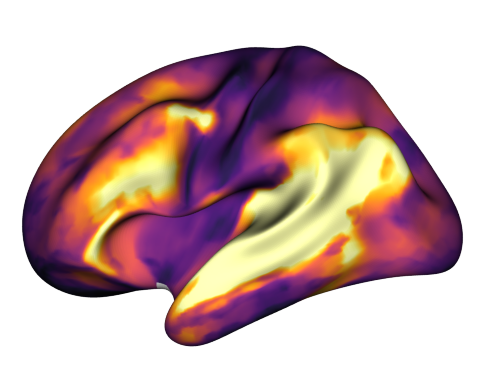

In [61]:
p = Plot(surf_lh=lh_surf, views='lateral', brightness=0.8)
p.add_layer(narratives[:40962], cbar=False, cmap='inferno', color_range=(0, .2))
# p.add_layer(threshold(narratives[:40962], 0.05), cbar=False, cmap='YlOrRd_r')
fig = p.build()

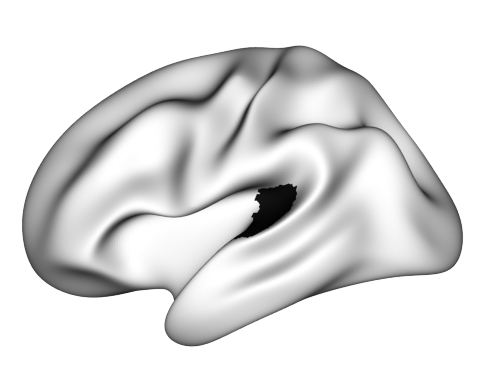

In [50]:
mask = glasser.roimask(['L_A1', 'L_LBelt', 'L_MBelt', 'L_PBelt', 'L_RI'])

p = Plot(surf_lh=lh_surf, views='lateral', brightness=0.8)
p.add_layer(mask.astype(int)[:40962], cbar=False, cmap='gray')
fig = p.build()

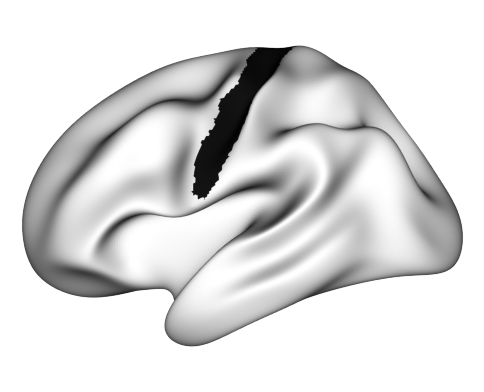

In [49]:
mask = glasser.roimask(['L_4', 'L_3a', 'L_3b'])

p = Plot(surf_lh=lh_surf, views='lateral', brightness=0.8)
p.add_layer(mask.astype(int)[:40962], cbar=False, cmap='gray')
fig = p.build()